In [1]:
import os, time
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.optimize import fmin

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc, rcParams
from linfitODR import linfit
%matplotlib inline


#switch off warnings
import warnings
warnings.filterwarnings("ignore")
#Style stuff:

rcParams.update({'errorbar.capsize': 0})
rc('text', usetex=True)
rc('font', size=11)
rc('legend', fontsize=11)
rcParams.update({'font.size':11})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

linestylesdict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def betafixed(b,xi,yi):
    zw = ((b-xi-yi)**2).sum()
    return np.sqrt(zw)

def linestyles(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:linestyles['densely dashed'], 
             3250:linestyles['densely dotted'],
             3500:linestyles['densely dashdotted'],
             3750:linestyles['densely dashdotdotted']}
        return c[Tmin]
    else: 
        return '-'

def markers(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:'o', 
             3250:'x',
             3500:'^',
             3750:'D'}
        return c[Tmin]
    else: 
        return '-'


def colorize(age):
    if age==0.125:
        return 'k'
    elif age == 0.63:
        return 'r'

def multicolorize(age):
    c = []
    for a in age:
        if a==0.125:
            c.append('k')
        elif a == 0.63:
            c.append('r')
    print(c)
    return c

def load(usecols=None, saturated=False, nosat=''):
    trange = {
               'M44': [
                       (3e3,7e3,'o', 5e28, 5e36, 0.630),   
                       (3e3,3.249e3,'o', 5e28, 5e36, 0.630),
                       (3.25e3,3.499e3,'o', 5e28, 5e36, 0.630),
                       (3.5e3,3.749e3,'o', 5e28, 5e36, 0.630),
                       (3.75e3,4e3,'o', 5e28, 5e36, 0.630),
                     ],
#               'M44 - no binaries': [
#                        (3e3,7e3,'s', 5e28, 5e36, 0.630),   
#                        (3e3,3.249e3,'s', 5e28, 5e36, 0.630),
#                        (3.25e3,3.499e3,'s', 5e28, 5e36, 0.630),
#                        (3.5e3,3.749e3,'s', 5e28, 5e36, 0.630),
#                        (3.75e3,4e3,'s', 5e28, 5e36, 0.630),
#                      ],


         'Pleiades': [
                      (3e3,7e3,'v', 5e28, 5e36, 0.125),
                      (3e3,3.249e3,'v', 5e28, 5e36, 0.125),
                      (3.25e3,3.499e3,'v', 5e28, 5e36, 0.125),
                      (3.5e3,3.749e3,'v', 5e28, 5e36, 0.125),
                      (3.75e3,4e3,'v', 5e28, 5e36, 0.125),
                      ],}

    df = pd.DataFrame()
    loc = 'stars_shortlist/share/'
    test='run_06'
    for key in trange.keys():
         for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
            if key == 'M44 - no binaries':
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD_nobin.csv'.format(loc,test,key[:3],Tmin,Tmax),
                                  usecols = usecols,
                                  dtype={'EPIC': np.int32, 'istart': np.int32, 
                                         'istop': np.int32})
                df2['nobin'] = True
                df2['clr'] = color
            else:
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD{}.csv'.format(loc,test,key,Tmin,Tmax,nosat),
                                  usecols = usecols,
                                  dtype={'EPIC': np.int32, 'istart': np.int32, 
                                         'istop': np.int32,})
                df2['nobin'] = False
                df2['clr'] = color

            df2['age'] = age
            df = df.append(df2)
    if saturated == True:
        dft = pd.read_csv('{}run_06_saturated10.csv'.format(loc),
                          usecols=['EPIC','istart','istop','saturated1','Tmax'],
                          dtype={'EPIC': np.int32, 'istart': np.int32, 
                                 'istop': np.int32, 'saturated1': np.int32})
        dft = dft[dft.Tmax==7000]

        print(df.shape,dft.shape)
        df = pd.merge(df, dft, how='left',on=['EPIC','istart','istop'])#,indicator==True)
    return df

    

def loadenergs(sharedthresh=False,nosat=''):

    dats = []
    for Tmin, Tmax, color in Tlims:
        locs2 = [#('M67','clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.3),
                 ('M45','stars_shortlist/share/{}_Pleiades_{}_{}_energs{}.csv'.format(test,Tmin,Tmax,nosat),0.125),
                 ('M44','stars_shortlist/share/{}_M44_{}_{}_energs{}.csv'.format(test,Tmin,Tmax,nosat),0.63),
                 #('M44 - no binaries','stars_shortlist/share/{}_M44_{}_{}_energs_nobin.csv'.format(test,Tmin,Tmax),0.63),
        ]

        for (name, value, age) in locs2:
            try:
                df = pd.read_csv(value,
                             usecols = ['clustered','clusterederr','clusterenergy',
                                        'clusterenergy_err','Teff',
                                        'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',#'rel_energ_err'
                                        'count_true','energ_true','tobs'],
                             )
                df['cluster'] = name

            except (FileNotFoundError, OSError):
                print('Nothing in {}-{} for {}'.format(Tmin,Tmax,name))
                continue
            #select color bin:
            print(df.shape)
            df = df[(df.Tmin == Tmin) & (df.Tmax == Tmax)]
            df = df[df.count_true < 5.]


            df = df.dropna(how='any')
            if df.shape[0] == 0:
                print('No high probability events.')
                t.threshold[name]=np.nan 
                #do not count threshold if nothing is detected because no relevance for interpretation
                continue
            detthr = t[(t.Tmin==Tmin) & (t.Tmax==Tmax)].threshold.max()
            if sharedthresh==True:
                detthr = 1.122e33 #for alpha/FA/FR comparison, highest threshold available
            df = df[df.energ_true > detthr]
            if df.shape[0] == 0:
                print('No high energy events.')
                continue
            n_stars = df.stars_in_bin.iloc[0]
            FAerr = np.sqrt( df.clusterenergy_err**2 + ( df.energ_true * df.L_bol_err /  df.L_bol )**2 ) /  df.L_bol
            
            dats.append([ age, n_stars, detthr,df.tobs.values[0],
                        np.sqrt((df.clusterenergy_err**2).sum())/n_stars,
                        df.energ_true.sum()/n_stars, 
                        df.shape[0]/n_stars,
                        df.shape[0],
                        Tmin,Tmax,
                        (df.energ_true/df.L_bol).sum(),
                         np.sqrt((FAerr**2).sum()),])
    dats = np.asarray(dats) 
    data = pd.DataFrame(dats, columns=['age','n_stars','threshold','dur',
                                       'tot_en_err','tot_en',
                                       'tot_flares_p_star','tot_flares',
                                       'Tmin','Tmax','FA','FA_err'])
    for col in data.columns.values:
        if col!= 'cluster':
            data[col] = data[col].astype('float')
            
    data['dursec'] = data.dur*365*24*60*60
    data['FA'] = data.FA/data.dursec
    data['FA_err'] = data.FA_err/data.dursec
    print(data.FA_err)
    data['tot_flares_p_yr'] = data.tot_flares/data.dur
    data['tot_flares_p_yr_err'] = np.sqrt(data.tot_flares)/data.dur
    
    data['tot_energ_true_per_time'] = data.tot_en/data.dursec
    data['tot_energ_true_per_time_err'] = data.tot_en_err/data.dursec
    data = data.sort_values(by='age')
    return data

Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c'),(3000.0,7000.0,'k'),]


In [2]:
#merge detection thresholds
run = '06'
threshs = pd.read_csv('stars_shortlist/share/run_{}_median_detection_thresholds_upperlimit.csv'.format(run))
#threshs = pd.read_csv('stars_shortlist/share/run_{}_median_detection_thresholds.csv'.format(run))

value_vars = ['Pleiades','M44','M67']
id_vars = ['Tmin','Tmax']
t = pd.melt(threshs, value_vars=value_vars, var_name='cluster',
            value_name='threshold', id_vars=id_vars)
#t = t[t.cluster !='M67']
#t.to_csv('stars_shortlist/share/run_{}_median_detection_thresholds_melted.csv'.format(run))
t

,Tmin,Tmax,cluster,threshold
0,3000,3249,Pleiades,4.781664e+32
1,3250,3499,Pleiades,5.870064e+32
2,3500,3749,Pleiades,1.300000e+33
3,3750,4000,Pleiades,1.370000e+33
4,3000,7000,Pleiades,8.467838e+32
5,4000,7000,Pleiades,2.213275e+33
6,3000,3249,M44,1.131709e+33
7,3250,3499,M44,5.715820e+32
8,3500,3749,M44,1.300000e+33
9,3750,4000,M44,1.370000e+33


In [17]:
ts = threshs.copy()
ts = ts.drop(['color','Unnamed: 0'],axis=1)
ts

,Tmin,Tmax,Pleiades,M44
0,3000,3249,4.781664e+32,1.131709e+33
1,3250,3499,5.870064e+32,5.715820e+32
2,3500,3749,1.300000e+33,1.300000e+33
3,3750,4000,1.370000e+33,1.370000e+33
4,3000,7000,8.467838e+32,7.680612e+32
5,4000,7000,2.213275e+33,1.325704e+33


In [18]:
ts.to_latex('stars_shortlist/share/Paper/thresholds.tex',
            escape=False,col_space=10,index=False,na_rep='')

In [3]:
usecols= ['Tmax','Tmin','alpha','alpha_err','beta','beta_err','maxenerg','n_obj','nflares','cluster',]
test = 'run_06'
res=load(usecols=usecols, nosat='_nosat').drop_duplicates()
df = load()
res['alpha']= -res.alpha
res['beta2'] = np.nan
res['beta2_high_err'] = np.nan
res['beta2_low_err'] = np.nan
for Tmax, f in df.groupby('Tmax'):
    for cluster, g in f.groupby('cluster'):

        arrbeta = []
        for i in range(g.shape[0]):
            xi = np.delete(g['logE'].values,i)
            yi = np.delete(g['count_per_yr'].values, i)
            arrbeta.append(fmin(betafixed,x0=30,args=(xi,yi),disp=0)[0])
        std = np.asarray(arrbeta).std()
        mean = np.asarray(arrbeta).mean()    
        res.beta2[(res.Tmax == Tmax) & (res.cluster == cluster)] = mean
        res.beta2_high_err[(res.Tmax == Tmax) & (res.cluster == cluster)] = np.sqrt(std**2 + g.high_yerr.median()**2)
        res.beta2_low_err[(res.Tmax == Tmax) & (res.cluster == cluster)] = np.sqrt(std**2 + g.low_yerr.median()**2)
        
res

,Tmax,Tmin,alpha,alpha_err,beta,beta_err,cluster,maxenerg,n_obj,nflares,nobin,clr,age,beta2,beta2_high_err,beta2_low_err
0,7000.0,3000.0,2.159305,0.016123,39.038067,0.536724,Pleiades,6.024272e+34,737,596,False,v,0.125,33.764480,0.053356,0.060842
0,3249.0,3000.0,2.051605,0.019852,34.899746,0.655397,Pleiades,6.024272e+34,224,94,False,v,0.125,33.187810,0.146666,0.223114
0,3499.0,3250.0,2.137402,0.027988,38.374125,0.929000,Pleiades,2.137683e+34,195,262,False,v,0.125,33.790751,0.085285,0.106228
0,3749.0,3500.0,2.369090,0.036633,46.133631,1.218530,Pleiades,2.298954e+34,130,179,False,v,0.125,33.840220,0.101138,0.132075
0,4000.0,3750.0,2.149913,0.066052,39.070992,2.204914,Pleiades,1.810352e+34,47,53,False,v,0.125,34.040511,0.127482,0.181198
0,7000.0,3000.0,2.214701,0.021228,40.140644,0.706115,M44,3.444738e+34,766,155,False,o,0.630,32.991423,0.116687,0.160042
0,3249.0,3000.0,2.047590,0.027088,34.507341,0.909730,M44,2.348061e+34,206,22,False,o,0.630,32.912272,0.288394,1.315928
0,3499.0,3250.0,2.131035,0.054078,37.506428,1.795637,M44,1.495831e+34,164,55,False,o,0.630,33.144622,0.198772,0.377161
0,3749.0,3500.0,2.021523,0.030490,34.008827,1.008250,M44,3.444738e+34,152,88,False,o,0.630,33.287401,0.126739,0.179718
0,4000.0,3750.0,2.012838,0.079076,33.399954,2.614073,M44,6.278819e+33,47,13,False,o,0.630,32.970605,0.201903,0.388983


In [20]:
ress = res.copy()
ress = ress[ress.nobin==False]
ress = ress[['cluster','Tmin','Tmax','n_obj','nflares',
             'alpha','alpha_err','beta','beta_err','beta2',
             'beta2_high_err','beta2_low_err']]
ress['beta2'] = '$' + ress.beta2.astype(str).str[:5] + '\\pm^{' + ress.beta2_high_err.astype(str).str[:4] + '}_{' + ress.beta2_low_err.astype(str).str[:4] + '}$'
ress['alpha'] = '$' + ress.alpha.astype(str).str[:5] + '\\pm' + ress.alpha_err.astype(str).str[:4] + '$'
ress['beta'] = '$' + ress.beta.astype(str).str[:5] + '\\pm' + ress.beta_err.astype(str).str[:4] + '$'
ress = ress.merge(t, how='left', on=['Tmin','Tmax','cluster'])
ress

,cluster,Tmin,Tmax,n_obj,nflares,alpha,alpha_err,beta,beta_err,beta2,beta2_high_err,beta2_low_err,threshold
0,Pleiades,3000,7000,737,596,$2.159\pm0.01$,0.016123,$39.03\pm0.53$,0.536724,$33.76\pm^{0.05}_{0.06}$,0.053356,0.060842,8.467838e+32
1,Pleiades,3000,3249,224,94,$2.051\pm0.01$,0.019852,$34.89\pm0.65$,0.655397,$33.18\pm^{0.14}_{0.22}$,0.146666,0.223114,4.781664e+32
2,Pleiades,3250,3499,195,262,$2.137\pm0.02$,0.027988,$38.37\pm0.92$,0.929000,$33.79\pm^{0.08}_{0.10}$,0.085285,0.106228,5.870064e+32
3,Pleiades,3500,3749,130,179,$2.369\pm0.03$,0.036633,$46.13\pm1.21$,1.218530,$33.84\pm^{0.10}_{0.13}$,0.101138,0.132075,1.300000e+33
4,Pleiades,3750,4000,47,53,$2.149\pm0.06$,0.066052,$39.07\pm2.20$,2.204914,$34.04\pm^{0.12}_{0.18}$,0.127482,0.181198,1.370000e+33
5,M44,3000,7000,766,155,$2.214\pm0.02$,0.021228,$40.14\pm0.70$,0.706115,$32.99\pm^{0.11}_{0.16}$,0.116687,0.160042,7.680612e+32
6,M44,3000,3249,206,22,$2.047\pm0.02$,0.027088,$34.50\pm0.90$,0.909730,$32.91\pm^{0.28}_{1.31}$,0.288394,1.315928,1.131709e+33
7,M44,3250,3499,164,55,$2.131\pm0.05$,0.054078,$37.50\pm1.79$,1.795637,$33.14\pm^{0.19}_{0.37}$,0.198772,0.377161,5.715820e+32
8,M44,3500,3749,152,88,$2.021\pm0.03$,0.030490,$34.00\pm1.00$,1.008250,$33.28\pm^{0.12}_{0.17}$,0.126739,0.179718,1.300000e+33
9,M44,3750,4000,47,13,$2.012\pm0.07$,0.079076,$33.39\pm2.61$,2.614073,$32.97\pm^{0.20}_{0.38}$,0.201903,0.388983,1.370000e+33


In [21]:
ress = ress.drop(['beta2_high_err','beta2_low_err','alpha_err','beta_err'],axis=1)
ress[['Tmax','Tmin']] = ress[['Tmax','Tmin']].astype(int)
ress.cluster = ress.cluster.replace('Pleiades','M45')
ress.threshold = ress.threshold.apply(lambda x: '{:.2f}'.format(np.round(np.log10(x),2)))
ress = ress.rename(index=str,columns={'Tmax':'$T_\\mathrm{max}$',
                                      'Tmin':'$T_\\mathrm{min}$',
                                      'alpha':'$\\alpha$',
                                      'beta':'$\\log\\beta$',
                                      'n_obj':'$n_*$',
                                      'nflares':'$n_\\mathrm{flares}$',
                                      'beta2':'$\\log\\beta_2$',
                                      'threshold':'$\\log E_\\mathrm{min}$'})
ress

,cluster,$T_\mathrm{min}$,$T_\mathrm{max}$,$n_*$,$n_\mathrm{flares}$,$\alpha$,$\log\beta$,$\log\beta_2$,$\log E_\mathrm{min}$
0,M45,3000,7000,737,596,$2.159\pm0.01$,$39.03\pm0.53$,$33.76\pm^{0.05}_{0.06}$,32.93
1,M45,3000,3249,224,94,$2.051\pm0.01$,$34.89\pm0.65$,$33.18\pm^{0.14}_{0.22}$,32.68
2,M45,3250,3499,195,262,$2.137\pm0.02$,$38.37\pm0.92$,$33.79\pm^{0.08}_{0.10}$,32.77
3,M45,3500,3749,130,179,$2.369\pm0.03$,$46.13\pm1.21$,$33.84\pm^{0.10}_{0.13}$,33.11
4,M45,3750,4000,47,53,$2.149\pm0.06$,$39.07\pm2.20$,$34.04\pm^{0.12}_{0.18}$,33.14
5,M44,3000,7000,766,155,$2.214\pm0.02$,$40.14\pm0.70$,$32.99\pm^{0.11}_{0.16}$,32.89
6,M44,3000,3249,206,22,$2.047\pm0.02$,$34.50\pm0.90$,$32.91\pm^{0.28}_{1.31}$,33.05
7,M44,3250,3499,164,55,$2.131\pm0.05$,$37.50\pm1.79$,$33.14\pm^{0.19}_{0.37}$,32.76
8,M44,3500,3749,152,88,$2.021\pm0.03$,$34.00\pm1.00$,$33.28\pm^{0.12}_{0.17}$,33.11
9,M44,3750,4000,47,13,$2.012\pm0.07$,$33.39\pm2.61$,$32.97\pm^{0.20}_{0.38}$,33.14


In [22]:
ress.to_latex('stars_shortlist/share/Paper/alphabeta.tex',
            escape=False,col_space=10,index=False,na_rep='',column_format='ccccccccc')

(1517, 22) (804, 5)
(1517, 24) ['Unnamed: 0' 'EPIC' 'Tmax_x' 'Tmin' 'alpha' 'alpha_err' 'beta' 'beta_err'
 'cluster' 'count_per_yr' 'high_yerr' 'istart' 'istop' 'logE' 'low_yerr'
 'maxenerg' 'n_obj' 'nflares' 'tobs' 'nobin' 'clr' 'age' 'Tmax_y'
 'saturated1']
(22, 24) (0, 24)
(67, 24) (0, 24)
(47, 24) (0, 24)
(230, 24) (0, 24)
(62, 24) (0, 24)
(165, 24) (0, 24)
(10, 24) (0, 24)
(53, 24) (0, 24)
(155, 24) (0, 24)
(594, 24) (0, 24)


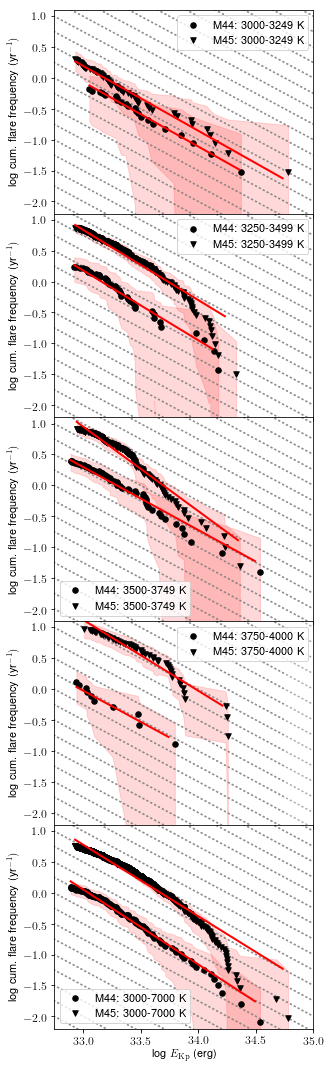

In [21]:

#df = load(saturated=True)
df =load(saturated=True, nosat='_nosat')
print(df.shape, df.columns.values)    
df = df.sort_values('Tmax_x')
df.to_csv('stars_shortlist/share/help.csv')
fig, ax = plt.subplots(ncols=1, nrows=5,figsize=(4.6,15), sharex=True, sharey=True)
i=0
for name, g in df.groupby('Tmax_x'):
    for cluster, f in g.groupby('cluster'):
        if cluster=='Pleiades':
            marker = 'v'
        else:
            marker = 'o'
        
        for binary, h in f.groupby('nobin'):
            cond = (res.cluster==cluster) & (res.Tmax ==name) & (res.nobin==binary)
            if cluster == 'Pleiades':
                cluster = 'M45'
            if binary == True:
                continue
            h = h.sort_values(by='logE')
            h1 = h[h.saturated1==False]
            h2 = h[h.saturated1==True]#>34.2]
            print(h1.shape,h2.shape)
            x2 = np.arange(h1.logE.min()-1,h1.logE.max()+1,0.1)
            for H in np.arange(30,40,0.25):
                ax[i].plot(x2,-1.*x2+H,linestyle='dotted',color='grey',zorder=1,alpha=0.65)
            if h1.shape[0] > 0:
                h1.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],
                         label='{}: {}-{} K'.format(cluster,int(f.Tmin.values[0]),int(name)),
                        marker=marker,color='k',s=30,zorder=2)
            if h2.shape[0] > 0:
                h2.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],marker=marker,s=30,
                       zorder=2)
                      
            ax[i].fill_between(h1.logE, h1.count_per_yr-h1.low_yerr, h1.count_per_yr+h1.high_yerr,
                             alpha=0.15,color='r')
            x = np.arange(h1.logE.min(),h1.logE.max(),0.1)
           
            ax[i].plot(x, -1.*(res.alpha[cond]-1.).values*x+res.beta[cond].values,
                      color='r',linewidth=2)

            ax[i].set_ylim(-2.2,1.1)
            ax[i].set_xlim(32.75,35)
            ax[i].set_ylabel('log cum. flare frequency (yr$^{-1})$')
            ax[i].tick_params(axis = 'both', labelsize = 12)

            
 
    ax[i].set_xlabel('log $E_\mathrm{Kp}$ (erg)')
    i+=1
    
    


plt.tight_layout()
plt.subplots_adjust(hspace=0)
#plt.savefig('stars_shortlist/share/Paper/FFDs_okt.png', dpi=300)

In [24]:
df = load(saturated=True)
print(df.columns.values)    
df = df.sort_values('Tmax')
fig, ax = plt.subplots(ncols=1, nrows=5,figsize=(4,15), sharex=True, sharey=True)
i=0
df.saturated1[df.saturated1==True]='c'
df.saturated1[df.saturated1==False]='k'
df.saturated1[df.saturated1.isnull()]='k'
for name, g in df.groupby('Tmax'):
    for cluster, f in g.groupby('cluster'):
        
        for binary, h in f.groupby('nobin'):
            cond = (res.cluster==cluster) & (res.Tmax ==name) & (res.nobin==binary)
            if cluster == 'Pleiades':
                cluster = 'M45'
            if binary == True:
                continue
            h = h.sort_values(by='logE')
            h1 = h[h.logE<34]
            h2 = h[h.logE>34]
            print(h2.columns.values)
            if h1.shape[0] > 0:
                h1.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],
                    label='{}: {}-{} K'.format(cluster,int(f.Tmin.values[0]),int(name)),
                    marker = h1.clr.iloc[0],
                    color=h1.saturated1,s=30)
            if h2.shape[0] > 0:
                h2.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],color=h2.saturated1,marker=h2.clr.iloc[0],s=30)
            ax[i].fill_between(h.logE, h.count_per_yr-h.low_yerr, h.count_per_yr+h.high_yerr,
                             alpha=0.15,color='r')
            x = np.arange(h.logE.min(),h.logE.max(),0.1)
           
            ax[i].plot(x, -1.*(res.alpha[cond]-1.).values*x+res.beta[cond].values,
                      color='r',linewidth=2)
            ax[i].set_ylim(-2.2,1.1)
            ax[i].set_ylabel('cumulative flare frequency (yr$^{-1})$')
            ax[i].tick_params(axis = 'both', labelsize = 12)

            
 
    ax[i].set_xlabel('log $E_\mathrm{Kp}$ (erg)')
    i+=1
    
    


plt.tight_layout()
plt.subplots_adjust(hspace=0)
#plt.savefig('stars_shortlist/share/Paper/FFDs.png', dpi=300)

(1583, 22) (804, 5)
['Unnamed: 0' 'EPIC' 'Tmax_x' 'Tmin' 'alpha' 'alpha_err' 'beta' 'beta_err'
 'cluster' 'count_per_yr' 'high_yerr' 'istart' 'istop' 'logE' 'low_yerr'
 'maxenerg' 'n_obj' 'nflares' 'tobs' 'nobin' 'clr' 'age' 'Tmax_y'
 'saturated1']


KeyError: 'Tmax'

### Plot alpha and FA/FR (T)


(94, 14)
(22, 14)
(262, 14)
(55, 14)
(179, 14)
(88, 14)
(53, 14)
(13, 14)
(596, 14)
(155, 14)
0    3.004487e-06
1    9.616930e-07
2    1.079337e-06
3    5.412737e-07
4    5.558835e-07
5    2.870853e-07
6    5.143271e-07
7    5.257160e-08
8    1.011098e-06
9    2.892214e-07
Name: FA_err, dtype: float64


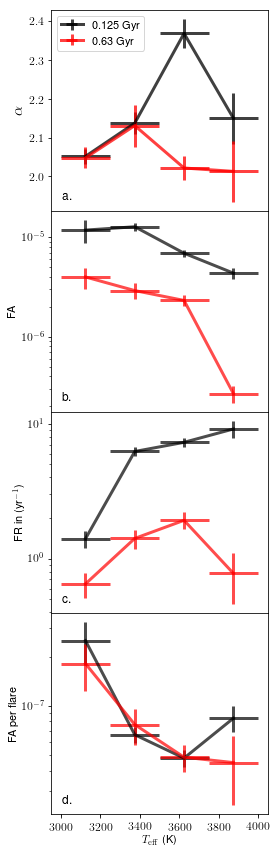

In [35]:
data = loadenergs(sharedthresh=True,nosat='_nosat')
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(4,12),sharex=True)
res = res[res.Tmax != 7000.]
#res = res[res.nobin == False]
data = data[data.Tmax != 7000.]
for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin

    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 linewidth=3,
                label='{} Gyr'.format(label),
                 alpha=0.75,color=colorize(label)
           )
    

    
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,legend=False,logy=True,
                 color= colorize(label))
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax4,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
           

ax4.set_xlabel(r'$T_\mathrm{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$', fontsize=16)

ax2.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax3.set_ylabel(r'FR in (yr$^{-1}$)')
ax4.set_ylabel(r'FA per flare')

ax1.tick_params(axis = 'both', labelsize = 12)
ax2.tick_params(axis = 'both', labelsize = 12)
ax3.tick_params(axis = 'both', labelsize = 12)
ax4.tick_params(axis = 'both', labelsize = 12)

ax1.text(0.05, 0.1, 'a.', transform=ax1.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax2.text(0.05, 0.1, 'b.', transform=ax2.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax3.text(0.05, 0.1, 'c.', transform=ax3.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax4.text(0.05, 0.1, 'd.', transform=ax4.transAxes,
      fontsize=12, fontweight='bold', va='top')

ax1.legend(loc=2)


plt.xlim(2950,4050)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.)
#plt.savefig('stars_shortlist/share/Paper/alphaFAFR_T2_okt.png', dpi=300)

(94, 14)
(22, 14)
(262, 14)
(55, 14)
(179, 14)
(88, 14)
(53, 14)
(13, 14)
(596, 14)
(155, 14)
0    3.004487e-06
1    9.616930e-07
2    1.079337e-06
3    5.412737e-07
4    5.558835e-07
5    2.870853e-07
6    5.143271e-07
7    5.257160e-08
8    1.011098e-06
9    2.892214e-07
Name: FA_err, dtype: float64


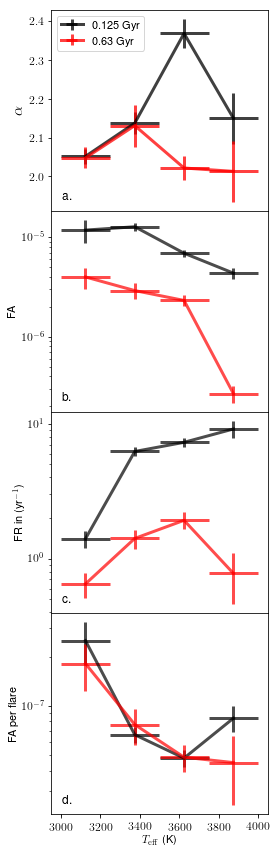

In [35]:
data = loadenergs(sharedthresh=True,nosat='_nosat')
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5, ncols=1, figsize=(4,15),sharex=True)
res = res[res.Tmax != 7000.]
#res = res[res.nobin == False]
data = data[data.Tmax != 7000.]
for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin

    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 linewidth=3,
                label='{} Gyr'.format(label),
                 alpha=0.75,color=colorize(label)
           )
    

    
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,legend=False,logy=True,
                 color= colorize(label))
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax4,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
    df.plot(x='midTbin',y='tot_energ_true_per_time',yerr='tot_energ_true_per_time_err',xerr='Terr',
                 kind='line', ax=ax5,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
           

ax5.set_xlabel(r'$T_\mathrm{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$', fontsize=16)

ax2.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax3.set_ylabel(r'FR in (yr$^{-1}$)')
ax4.set_ylabel(r'FA per flare')

ax1.tick_params(axis = 'both', labelsize = 12)
ax2.tick_params(axis = 'both', labelsize = 12)
ax3.tick_params(axis = 'both', labelsize = 12)
ax4.tick_params(axis = 'both', labelsize = 12)

ax1.text(0.05, 0.1, 'a.', transform=ax1.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax2.text(0.05, 0.1, 'b.', transform=ax2.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax3.text(0.05, 0.1, 'c.', transform=ax3.transAxes,
      fontsize=12, fontweight='bold', va='top')
ax4.text(0.05, 0.1, 'd.', transform=ax4.transAxes,
      fontsize=12, fontweight='bold', va='top')

ax1.legend(loc=2)


plt.xlim(2950,4050)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.)
#plt.savefig('stars_shortlist/share/Paper/alphaFAFR_T2_okt.png', dpi=300)

## Alpha vs Beta

3000.0
3000.0
3250.0
3250.0
3500.0
3500.0
3750.0
3750.0
[ 35.91801891 -38.75234424] [1.00209386 2.10371872]


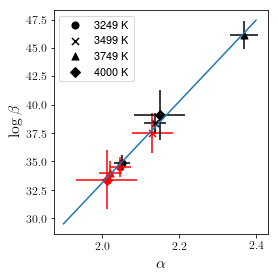

In [7]:

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
res = res[res.Tmax != 7000]
res = res[res.nobin == False]
for name, f in res.groupby('Tmax'):
    for age, df in f.groupby('age'):
        if age==0.125:
            l='{} K'.format(int(name))
        else:
            l=None
        print(df.Tmin[0])
        df.plot(x='alpha', y='beta', xerr='alpha_err', yerr='beta_err',
                kind='scatter',label=l,marker=markers(df.Tmin[0],df.Tmax[0]),
                s=50,color=colorize(df.age[0]),
                ax=ax) 

m,c = linfit(res.alpha,res.beta,res.alpha_err,res.beta_err)

x = np.arange(1.9,2.45,0.1)
print(m,c)
ax.plot(x,x*m[0]+m[1])
ax.tick_params(axis = 'both', labelsize = 12)

plt.xlabel(r'$\alpha$',fontsize=16)
plt.ylabel(r'$\log\beta$',fontsize=16)
plt.tight_layout()
plt.savefig('stars_shortlist/share/Paper/alpha_vs_beta_okt.png',dpi=300)

## Alpha=2 vs Beta2

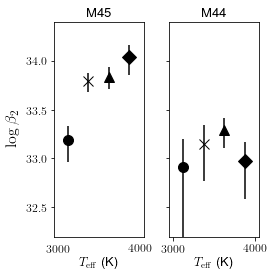

In [12]:

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(4,4),sharey=True)
res = res[res.Tmax != 7000]
res['alpha2'] = 2

for name, f in res.groupby('Tmax'):
    for age, df in f.groupby('age'):
        if age==0.125:
            title = 'M45'
            l = name
            j = 0
        else:
            title = 'M44'
            l=None
            j=1
   
        yerr= np.asarray([df.beta2_low_err.values,df.beta2_high_err.values])
        ax[j].errorbar(name-125, df.beta2.values, yerr=yerr,
                label=l,marker=markers(df.Tmin[0],df.Tmax[0]),
                markersize=10.,color='k',) 
        ax[j].set_title(title)
        ax[j].set_xlabel(r'$T_\mathrm{eff}$ (K)',fontsize=13)
        ax[j].set_ylim(32.2,34.4)
        ax[j].set_xlim(2950,4050)
        ax[j].tick_params(axis = 'both', labelsize = 12)


  
        
ax[0].set_ylabel(r'$\log\beta_2$',fontsize=16)
plt.legend(loc=3)
ax[0].tick_params(axis='x', bottom='off') 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0., hspace=None)
plt.tight_layout()
plt.savefig('stars_shortlist/share/Paper/fixedalpha2_vs_beta_okt.png',dpi=300)

### Plot total energy, total number of flares per cluster

(94, 14)
(22, 14)
(269, 14)
(55, 14)
(185, 14)
(88, 14)
(53, 14)
(13, 14)
(647, 14)
(157, 14)
0    3.004487e-06
1    9.616930e-07
2    1.064952e-06
3    5.412737e-07
4    5.485634e-07
5    2.870853e-07
6    5.143271e-07
7    5.257160e-08
8    9.908774e-07
9    2.884664e-07
Name: FA_err, dtype: float64
3249.0
3499.0
3749.0
4000.0
(94, 14)
(22, 14)
(269, 14)
(55, 14)
(185, 14)
(88, 14)
(53, 14)
(13, 14)
(647, 14)
(157, 14)
0    3.004487e-06
1    9.616930e-07
2    1.080569e-06
3    5.479324e-07
4    5.476952e-07
5    2.867392e-07
6    5.137693e-07
7    5.153571e-08
8    9.925974e-07
9    2.895756e-07
Name: FA_err, dtype: float64
3249.0
3499.0
3749.0
4000.0


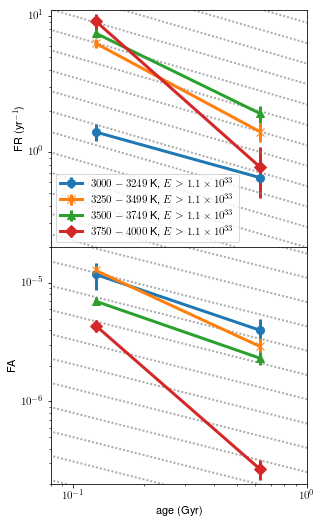

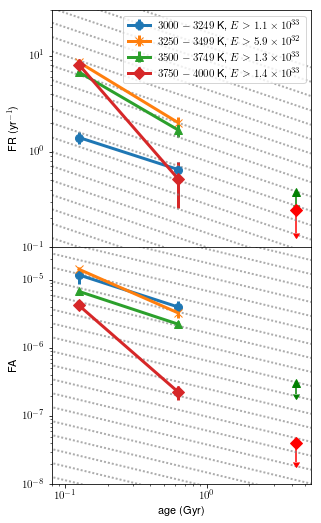

In [30]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

sharedthresh = [True,False]
test = 'run_06'

for b in sharedthresh: 
    data = loadenergs(b)
    if b==True:
        thr = '_thr'
    else:
        thr = ''
    fig, (ax2,ax1) = plt.subplots(nrows=2, ncols=1,figsize=(4.6,7.4),sharex=True)

    time = np.arange(0.02,5.5,0.01)
    skum1 = 0.00000005*np.sqrt(1/time)
    skumno1 = 0.0005/time
    skum2 = 0.01*np.sqrt(1/time)
    skumno = 1/time
    data = data[data.Tmax != 7000.]
    for label, df in data.groupby(['Tmax','Tmin']):
        df = df.sort_values(by='age')

        df['FA_FR'] =df.FA/df.tot_flares
        df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
     
        df.plot(x='age',y='FA',yerr='FA_err',
                     kind='line', ax=ax1,linewidth=3,
                     markersize=8,capsize=0,loglog=True,
                      marker=markers(label[1],label[0]),legend=False
                   )
        df.plot(x='age',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                     kind='line', ax=ax2,linewidth=3,
                     markersize=8,capsize=0,loglog=True,
                     label=r'${:.0f}-{:.0f}$\,K, $E>{}$'.format(label[1],label[0],
                                                             latex_float(df.threshold.max())),#{:.1E}
                     #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                        marker=markers(label[1],label[0]),)

        print(label[0])
    A = np.power(10,np.arange(-3.6,3,0.205))
    B = np.power(10,np.arange(-1.1,3.5,0.15))
    for a in A[5:]:
        ax1.plot(time, a*skum1,linewidth=2,linestyle=linestylesdict['densely dotted'],
                 color='grey',alpha=0.65)#,label=r'$t^{-1/2}$')   
    for a in B[6:-1]:    
        ax2.plot(time, a*skum2,linewidth=2,linestyle=linestylesdict['densely dotted'],
                 color='grey',alpha=0.65) 

    ax1.set_xlabel('age (Gyr)')
    #ax3.set_xlabel('age (Gyr)')
    #ax3.set_ylabel(r'FA per flare')
    ax1.set_ylabel(r'FA')# in erg$\cdot$yr$^{-1}$')
    ax2.set_ylabel(r'FR (yr$^{-1}$)')

    ax2.legend(loc=3,fontsize='medium')

    ax2.set_xlim(0.08,1)

    ax2.set_ylim(0.2,11)
    ax1.set_ylim(2e-7,2e-5)
    
    if b==False:
        ax1.set_xlim(0.08,5.5)
        ax1.set_ylim(1e-8,3e-5)
        ax2.set_ylim(0.1,30)
        ax2.legend(loc=1)
        s=8
        yerr = 0.1
        yerr2 = 1e-7
        ax2.errorbar([4.3],[1./2.64], markersize=s, marker='^', color='g', yerr=yerr, uplims=True)
        ax2.errorbar([4.3],[1./4.125], markersize=s, marker='D', color='r', yerr=yerr, uplims=True)
        ax1.errorbar([4.3],[3.1e-7], markersize=s, marker='^', color='g', yerr=yerr2, uplims=True)
        ax1.errorbar([4.3],[4.1e-8], markersize=s, marker='D', color='r', yerr=2e-8, uplims=True)


    
    
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.)
    plt.savefig('stars_shortlist/share/Paper/FAFR_age{}_okt.png'.format(thr),dpi=300)
    #plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFR1e33.png',dpi=300)

In [6]:
1.3/1.33*10/365/24/3600

3.0994533517965385e-07

In [7]:
1.37/2.57/4.125/365/24/360

4.0978578014627985e-08

# DEPRECATED

## FFD Slopes 

In [ ]:

plt.figure(figsize=(7,6))
pleiades = res[res.age==0.125]
tmin = {3249.:31.9,
        3499.:32.,
        3749.:32.1,
        4000.:32.2,
        7000.:32.1,}
for i, row in pleiades.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='k',linewidth=3,label='{}-{} K'.format(int(row.Tmin),int(row.Tmax)))
m44 = res[res.age==0.63]
tmin = {3249.:31.8,
        3499.:31.9,
        3749.:31.9,
        4000.:32.,
        7000.:31.9,}
for i, row in m44.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='red',linewidth=3,)
plt.legend()#bbox_to_anchor=(0.6,0.27))

plt.xlabel('log( $E_{Kp,flare}$ (erg) )')
plt.ylabel(r'log( frequency in (h$^{-1}$) )')
# ax2.set_xlabel('log(energy in erg)')
# ax2.set_ylabel(r'log(frequency in h$^{-1}$)')
plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/slopes.png',dpi=300)


In [ ]:
#Prep FFD results

#Unrestrictive Prep (only merging and shuffling results)
#os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/run_05')
os.chdir('/work1/eilin/data/CLUSTERS_01/Archive_MA_12072018/stars_shortlist_share')
today = time.strftime("%d_%b_%Y", time.gmtime())
run = '05'
locs = [
        ('M44','M44_run_{}_cum_FFD.csv'.format(run),0.630),
        ('Pleiades','Pleiades_run_{}_cum_FFD.csv'.format(run),0.125)]

frames = []
for (key, value,age) in locs:
    df = pd.read_csv(value,
                     usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'maxenerg','n_obj','nflares'],
                     )
    frames.append(df)
res = pd.concat(frames, keys=[x[2] for x in locs])
res = res.reset_index()
res = res.drop('level_1',axis=1)
res = res.rename(index=str, columns={'level_0':'age'})
ages = {4.3:'M67',0.630:'M44',0.125:'Pleiades'}
res['cluster'] = [ages[i] for i in res.age]
res = res.dropna(how='any')
#Transform alpha to conventional value
res.alpha = -res.alpha+1.

#Restrictive Prep (actual changes to the tabled results)

res.Tmax[(res.age==0.12) & (res.Tmin == 3750.)]=4000.
res = res[(res.Tmax-res.Tmin < 500) | (res.Tmax-res.Tmin > 3000)]
res.Tmax[res.Tmax == 3999.] = 4000.
res = res.sort_values(by='Tmax')


res = newres
res

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(13,4))

data = data[data.Tmax != 7000.]
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax1,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,
                 label='{} Gyr'.format(label))#, color=colors(label[1],label[0]))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,capsize=5,legend=False,logy=True,
                 #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                    #color=colors(label[1],label[0]),
           )
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,legend=False
                 )
           
   # print(label[0])

#ax2.plot(time, skumno,linewidth=2,linestyle='dashed',color='k') 
#ax1.plot(time, skumno1,linewidth=2,linestyle='dashed',color='k') 
ax1.set_xlabel(r'$T_{eff}$ (K)')
ax2.set_xlabel(r'$T_{eff}$ (K)')
ax3.set_xlabel(r'$T_{eff}$ (K)')
ax1.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax2.set_ylabel(r'FR in (yr$^{-1}$)')
ax3.set_ylabel(r'FA per flare')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')
ax1.legend()
plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFRofT.png',dpi=300)

## alpha (age)

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,64),sharex=True)
for label, df in res.groupby(['Tmax','Tmin']):
  
    print(label[0])
    df.plot(x='age',y='alpha',yerr='alpha_err',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                 label='{}-{} K'.format(int(label[1]),int(label[0])), 
                 linestyle=colors(label[1],label[0]),
                 alpha=0.75,
           )
    
    
ax1.legend(bbox_to_anchor=(0.6,0.27))
ax1.set_xlabel('age (Gyr)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('age (Gyr)')
ax2.set_ylabel(r'$\log\beta$')
plt.xlim(0,0.8)


plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabeta.png',dpi=300)

## Uncertainties on energy etc. from MA_thesis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
#print(os.getcwd())
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist')
Tmin,Tmax=3000.0,7000.0

locs2 = [('Pleiades','share/run_05/clusterenergies_Pleiades_run_05_{}_{}.csv'.format(Tmin,Tmax),0.120,'green'),
         ('M44','share/run_05/clusterenergies_M44_run_05_{}_{}.csv'.format(Tmin,Tmax),0.8,'orange'),
         ('M67','share/run_05/clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.0,'blue')]
for (name, value, age,color) in locs2:
    vars()[name] = pd.read_csv(value,
                     usecols = ['clustered','clusterederr','clusterenergy',
                                'clusterenergy_err','rel_energ_err','Teff',
                                'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',
                                'count_true','energ_true','EPIC'],
                     )
#M67=M67[M67.count_true==1.6]
#M44[M44.Teff > 4000].count()#5170K 3 flares???
#Pleiades[Pleiades.Teff > 4000].sort_values(by='Teff').count()#4620,5170,4410,
#M44.groupby('EPIC').count().shape

In [ ]:

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'jet'
#import matplotlib.pylab as pl
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1,sharey=True,figsize=(10,3),squeeze=True)
for (name, value, age,color) in locs2:
    x = vars()[name]
    if name=='M67': a=20
    else: a=1
    ax1.hist(np.repeat(x.L_bol_err/x.L_bol,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax1.set_xlabel(r'$\sigma _{L_{bol}} / L_{bol}$')
    ax2.hist(np.repeat(x.clusterederr/x.clustered,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax2.set_xlabel(r'$\sigma _{ED} / ED$')
    ax3.hist(np.repeat(x.rel_energ_err,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax3.set_xlabel(r'$\sigma _{E_{Kp,flare}} /E_{Kp,flare}$')
plt.ylim(.1,350)
plt.xlim(0,2)

plt.legend(bbox_to_anchor=(0.85,0.80))
fig.tight_layout(pad=0)
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/relerr.png',dpi=300)

In [ ]:
for (name, value, age) in locs2:
    x = vars()[name]
    x = x[x.count_true < 5.]
    print(r'{:8} mean relative error on ED         is {:.2f}$\pm${:.2f}.'.format(name, (x.clusterederr/x.clustered).mean(),(x.clusterederr/x.clustered).std()))
    print(r'{:8} mean relative error on energy     is {:.2f}$\pm${:.2f}.'.format(name, (x.rel_energ_err).mean(),(x.rel_energ_err).std()))
    print(r'{:8} mean relative error on luminosity is {:.2f}$\pm${:.2f}.'.format(name, (x.L_bol_err/x.L_bol).mean(),(x.L_bol_err/x.L_bol).std()))

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,7),sharex=True)
res = res[res.Tmax != 7000]

for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df.plot(x='midTbin',y='beta',yerr='beta_err',xerr='Terr',
      kind='line', ax=ax2,legend=False,
                 markersize=10,linewidth=5,marker='o',alpha=0.75,
            label='{} Gyr'.format(label),
                       )
    
    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                label='{} Gyr'.format(label),
                 alpha=0.75,
           )
ax1.legend(bbox_to_anchor=(0.55,0.15))

ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('$T_{eff}$ in (K)')
ax2.set_ylabel(r'$\log\beta$')

plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabetaofT.png',dpi=300)
#.format(today)